In [1]:
import pandas as pd
import numpy as np
import os.path
from os import path
from datetime import datetime
from dataCleaning import DataCleaner
from scipy.stats import norm
import math

In [45]:
data_months = range(1, 13)
data_years = range(2017, 2021)

topK = 10
data = {}
cleaner = DataCleaner(columns=["OptionType", "expirydate", "date", "strike", "spotclose", "close2", "volume"],
                          date_columns=["date", "expirydate"], verbose=False)
for year in data_years:
    for month in data_months:
        if month < 10:
            name = "SPX_{}0{}_1day".format(year, month)
        else:
            name = "SPX_{}{}_1day".format(year, month)
        if not path.exists("./SPXdata/{}.csv".format(name)):
            continue
        cleaner.insert_data(data, name, "USD3MTD156N", topK)
        print("Added Year: {}, Month: {} data".format(year, month))

cleaner.get_num_days()
cleaner.get_num_observation()



Added Year: 2017, Month: 4 data
Added Year: 2017, Month: 5 data
Added Year: 2017, Month: 6 data
Added Year: 2017, Month: 7 data
Added Year: 2017, Month: 8 data
Added Year: 2017, Month: 9 data
Added Year: 2017, Month: 10 data
Added Year: 2017, Month: 11 data

KeyboardInterrupt: 

## Step 1: Initialize prior parameters

In [18]:
### initialize priors omega, alpha, beta, W, v

## W ~ InverseGamma(a_0, b_0) ############################################################################

a_0 = 1
b_0 = 1
#sampleing
phi = np.random.gamma(shape = a_0, scale = 1/b_0)
W = 1/phi


## Beta = (omega, alpha, beta) ~ MVN(mu_0, Lambda_0^{-1}/phi) ############################################
Lambda_0 = np.array([[3, 0, 0],
                     [0, 3, 0],
                     [0, 0, 3]])
mu_0 = np.array([0.5, 0.5, 0.5])
#sampleing

def SatisfyConstrains(Beta):
    if Beta[0]<0 or Beta[1]<0 or Beta[2]<0 or Beta[1]+Beta[2]>1:
        return False
    return True

HaveSample = False
while not HaveSample:
    Beta = np.random.multivariate_normal(mean = mu_0, cov = np.linalg.inv(Lambda_0) / phi)
    HaveSample = SatisfyConstrains(Beta)


# Beta = np.array([0.82012376, 0.62187522, 0.26997804])
omega = Beta[0]
alpha = Beta[1]
beta = Beta[2]


## v ~ InverseGamma(delta, epsilon) ######################################################################
delta = 1
epsilon = 1
#sampleing
tau = np.random.gamma(shape= delta, scale = 1/epsilon)
v = 1/tau


## theta_0 ~ normal(m_0, C_0) ############################################################################
m_0 = 0.0004
C_0 = 1
theta_0 = np.random.normal(m_0, C_0)



## Step 2: Forward Filtering

In [19]:
# Prepare update g_{t} and BS f_{ti} function

def g_t(u_t, theta_t_1, o=omega, a=alpha, b=beta):
    return o + a* (u_t**2) + b * theta_t_1

def f_t_parallel(theta_t, p_t, r_t, K_t, T_t):
    """
    :params K_t is a 1D np array
    :params T_t is a 1D np array
    """
    d_pls = np.divide(np.log(p_t/ K_t) + np.multiply( r_t+theta_t/2, T_t), np.sqrt(theta_t * T_t))
    d_mns = np.divide(np.log(p_t/ K_t) + np.multiply( r_t-theta_t/2, T_t), np.sqrt(theta_t * T_t))
    y_ti = np.multiply(p_t, norm.cdf(d_pls)) - np.multiply(np.multiply(K_t, np.exp(- r_t * T_t)), norm.cdf(d_mns))
    return y_ti
    
def f_ti_single(theta_t, p_t, r_t, K_ti, T_ti):
    d_pls = (log(p_t/ K_ti) + (r_t + theta_t/2) * T_ti  ) / sqrt(theta_t * T_ti)
    d_mns = (log(p_t/ K_ti) + (r_t - theta_t/2) * T_ti  ) / sqrt(theta_t * T_ti)
    y_ti = p_t * norm.cdf(d_pls) - K_ti * exp(- r_t * T_ti) * norm.cdf(d_mns)
    return y_ti

def F_t_Trans_parallel(theta_t, p_t, r_t, K_t, T_t):
    """
    :params K_t is a 1D np array
    :params T_t is a 1D np array
    """
    d_pls = np.divide( np.log(p_t/ K_t) + np.multiply(r_t + a_t/2, T_t), np.sqrt(np.multiply(a_t, T_t)))
    d_mns = np.divide( np.log(p_t/ K_t) + np.multiply(r_t - a_t/2, T_t), np.sqrt(np.multiply(a_t, T_t)))
    bracket1 = np.multiply(np.log(p_t/K_t)*(1/a_t), (1/T_t)) + r_t*(1/a_t)
    bracket2 = np.multiply(K_t, np.exp(-r_t*T_t))*norm.pdf(d_mns) - p_t*norm.pdf(d_pls) 
    bracket3 = np.multiply(K_t, np.exp(-r_t*T_t))*norm.pdf(d_mns) + p_t*norm.pdf(d_pls) 
    F_t_Trans = 1/2*np.multiply(np.multiply(np.sqrt(T_t/a_t), bracket1), bracket2) + 1/4*np.multiply(np.sqrt(T_t/a_t), bracket3)
    return F_t_Trans
    
def F_ti_Trans_single(a_t, p_t, r_t, K_ti, T_ti):
    d_pls = (log(p_t/ K_ti) + (r_t + a_t/2) * T_ti  ) / sqrt(a_t * T_ti)
    d_mns = (log(p_t/ K_ti) + (r_t - a_t/2) * T_ti  ) / sqrt(a_t * T_ti)
    bracket1 = log(p_t/K_ti) * (1/a_t) * (1/T_ti) + r_t * (1/a_t)
    bracket2 = K_ti*exp(-r_t*T_ti)*norm.pdf(d_mns) - p_t*norm.pdf(d_pls) 
    bracket3 = K_ti*exp(-r_t*T_ti)*norm.pdf(d_mns) + p_t*norm.pdf(d_pls) 
    F_ti = 1/2*sqrt(T_ti/a_t)*bracket1*bracket2 + 1/4*sqrt(T_ti/a_t)*bracket3
    return F_ti_Trans
    

In [20]:
Ms = [m_0] # Don't forget to remove the first element which is for theta_0
Cs = [C_0] # Don't forget to remove the first element which is for theta_0
Us = []

delta_y_f = 0

all_days = sorted(list(data.keys()))
for day in all_days:
    # get observable data
    ## Stock Wise and market wise data
    p_t = data[day][0]["spotclose"].values[0]
    r_t = math.log(data[day][1], 260)
    u_t = data[day][2]
    Us.append(u_t)
    
    ## Option wise data
    y_t = data[day][0]["close2"].values
    K_t = data[day][0]["strike"].values
    today = [d.date() for d in data[day][0]["date"]]
    expireday = [d.date() for d in data[day][0]["expirydate"]]
    T_t = np.busday_count(today, expireday)
    
    # Calculate model wise data
    a_t = g_t(u_t, Ms[-1])
    G_t = beta
    R_t = G_t**2 * Cs[-1] + W
    F_t_Trans = F_t_Trans_parallel(a_t, p_t, r_t, K_t, T_t)
    h_t = f_t_parallel(a_t, p_t, r_t, K_t, T_t) - F_t_Trans
    xi_t = y_t - h_t
    
    # Update delta_y_f
    delta_y_f += np.sum(np.power(y_t - f_t_parallel(a_t, p_t, r_t, K_t, T_t), 2))
    
    # Update parameter
    m_t = (R_t * np.sum(np.multiply(F_t_Trans, xi_t)) + v*a_t) / (np.sum(np.multiply(F_t_Trans, F_t_Trans)) + v)
    C_t = (v* R_t) / (np.sum(np.multiply(F_t_Trans, F_t_Trans)) + v)
  
    Ms.append(m_t)
    Cs.append(C_t)

## Backward Smoothing

In [21]:
theta_back = []
Ms_star = [Ms[-1]]
Cs_star = [Cs[-1]]
T = len(Ms)

for t in range(T-1, 0, -1):
    theta_t_backward = np.random.normal(Ms_star[-1], Cs_star[-1])
    theta_back.insert(0, theta_t_backward)
    G_t = beta
    C_t_1 = Cs[t-1]
    R_t = G_t*C_t_1*G_t + W
    J_t_1 = C_t_1*G_t*(1/R_t)
    
    u_t = Us[t-1]
    m_t_1_backward = Ms[t-1] + J_t_1*(theta_t_backward-g_t(Ms[t-1], u_t, o=omega, a=alpha, b=beta))
    C_t_1_backward = C_t_1 - J_t_1*R_t*J_t_1
    
    Ms_star.append(m_t_1_backward)
    Cs_star.append(C_t_1_backward)

theta0 = np.random.normal(Ms_star[-1], Cs_star[-1])
theta_back.insert(0, theta_0)
T -= 1

## Linear Regression with Constraints

In [22]:
# Make Design Matrix
Theta = np.array(theta_back[1:]).reshape([T,1])
component1=np.ones((T, 1))
component2=np.multiply(np.array(Us), np.array(Us)).reshape([T,1])
component3=np.array(theta_back[:-1]).reshape([T,1])
X = np.concatenate( (component1, component2, component3), axis=1)

Lambda_n = np.matmul(X.T, X) + Lambda_0
mu_n = np.matmul(np.linalg.inv(Lambda_n), (np.matmul(Lambda_0, mu_0.reshape([3,1])) + np.matmul(X.T, Theta)))
a_n = a_0 + T/2
b_n = b_0 + 1/2*(np.matmul(Theta.T, Theta) + np.matmul(mu_0.T, np.matmul(Lambda_0, mu_0)) + np.matmul(mu_n.T, np.matmul(Lambda_n, mu_n)))

phi_new = np.random.gamma(a_n, 1/b_n)
W_new = 1/phi_new

HaveSample = False
while not HaveSample:
    Beta_new = np.random.multivariate_normal(mu_n.reshape(3), np.linalg.inv(Lambda_n)/phi_new)
    HaveSample = SatisfyConstrains(Beta_new)

## Inverse Gamma

In [23]:
delta_new = delta + T*topK/2
epsilon_new = epsilon + 1/2*delta_y_f

tau_new = np.random.gamma(delta_new, 1/epsilon_new)

# Sum up MCMC

In [29]:
traj_W = []
traj_omega = []
traj_alpha = []
traj_beta = []
traj_v = []
traj_theta_0 = []


for itr in range(100):
    Ms = [m_0] # Don't forget to remove the first element which is for theta_0
    Cs = [C_0] # Don't forget to remove the first element which is for theta_0
    Us = []

    delta_y_f = 0

    all_days = sorted(list(data.keys()))
    for day in all_days:
        # get observable data
        ## Stock Wise and market wise data
        p_t = data[day][0]["spotclose"].values[0]
        r_t = math.log(data[day][1], 260)
        u_t = data[day][2]
        Us.append(u_t)

        ## Option wise data
        y_t = data[day][0]["close2"].values
        K_t = data[day][0]["strike"].values
        today = [d.date() for d in data[day][0]["date"]]
        expireday = [d.date() for d in data[day][0]["expirydate"]]
        T_t = np.busday_count(today, expireday)

        # Calculate model wise data
        a_t = g_t(u_t, Ms[-1])
        G_t = beta
        R_t = G_t**2 * Cs[-1] + W
        F_t_Trans = F_t_Trans_parallel(a_t, p_t, r_t, K_t, T_t)
        h_t = f_t_parallel(a_t, p_t, r_t, K_t, T_t) - F_t_Trans
        xi_t = y_t - h_t

        # Update delta_y_f
        delta_y_f += np.sum(np.power(y_t - f_t_parallel(a_t, p_t, r_t, K_t, T_t), 2))

        # Update parameter
        m_t = (R_t * np.sum(np.multiply(F_t_Trans, xi_t)) + v*a_t) / (np.sum(np.multiply(F_t_Trans, F_t_Trans)) + v)
        C_t = (v* R_t) / (np.sum(np.multiply(F_t_Trans, F_t_Trans)) + v)

        Ms.append(m_t)
        Cs.append(C_t)


    theta_back = []
    Ms_star = [Ms[-1]]
    Cs_star = [Cs[-1]]
    T = len(Ms)

    for t in range(T-1, 0, -1):
        theta_t_backward = np.random.normal(Ms_star[-1], Cs_star[-1])
        theta_back.insert(0, float(theta_t_backward))
        G_t = beta
        C_t_1 = Cs[t-1]
        R_t = G_t*C_t_1*G_t + W
        J_t_1 = C_t_1*G_t*(1/R_t)

        u_t = Us[t-1]
        m_t_1_backward = Ms[t-1] + J_t_1*(theta_t_backward-g_t(Ms[t-1], u_t, o=omega, a=alpha, b=beta))
        C_t_1_backward = C_t_1 - J_t_1*R_t*J_t_1

        Ms_star.append(m_t_1_backward)
        Cs_star.append(C_t_1_backward)

    theta0 = np.random.normal(Ms_star[-1], Cs_star[-1])
    theta_back.insert(0, float(theta_0))
    T -= 1


    # Make Design Matrix
    Theta = np.array(theta_back[1:]).reshape([T,1])
    component1=np.ones((T, 1))
    component2=np.multiply(np.array(Us), np.array(Us)).reshape([T,1])
    component3=np.array(theta_back[:-1]).reshape([T,1])
    X = np.concatenate( (component1, component2, component3), axis=1)

    Lambda_n = np.matmul(X.T, X) + Lambda_0
    mu_n = np.matmul(np.linalg.inv(Lambda_n), (np.matmul(Lambda_0, mu_0.reshape([3,1])) + np.matmul(X.T, Theta)))
    a_n = a_0 + T/2
    b_n = b_0 + 1/2*(np.matmul(Theta.T, Theta) + np.matmul(mu_0.T, np.matmul(Lambda_0, mu_0)) + np.matmul(mu_n.T, np.matmul(Lambda_n, mu_n)))

    phi_new = np.random.gamma(a_n, 1/b_n)
    W_new = 1/phi_new

    HaveSample = False
    while not HaveSample:
        Beta_new = np.random.multivariate_normal(mu_n.reshape(3), np.linalg.inv(Lambda_n)/phi_new)
        HaveSample = SatisfyConstrains(Beta_new)

    delta_new = delta + T*topK/2
    epsilon_new = epsilon + 1/2*delta_y_f

    tau_new = np.random.gamma(delta_new, 1/epsilon_new)
    v_new = 1/tau_new
    
    ## Update all parameters
    phi = phi_new
    W = W_new
    Beta = Beta_new
    omega = Beta[0]
    alpha = Beta[1]
    beta = Beta[2]
    tau = tau_new
    v = v_new
    theta_0 = theta0
    
    traj_W.append(float(W))
    traj_omega.append(float(omega))
    traj_alpha.append(float(alpha))
    traj_beta.append(float(beta))
    traj_v.append(float(v))
    traj_theta_0.append(float(theta_0))
    
    if itr % 10 == 0:
        print(itr)

0
10
20
30
40
50
60
70
80
90


In [31]:
import matplotlib.pyplot as plt
import plotly
import plotly.graph_objects as go
import matplotlib as mpl
import seaborn as sns
import os

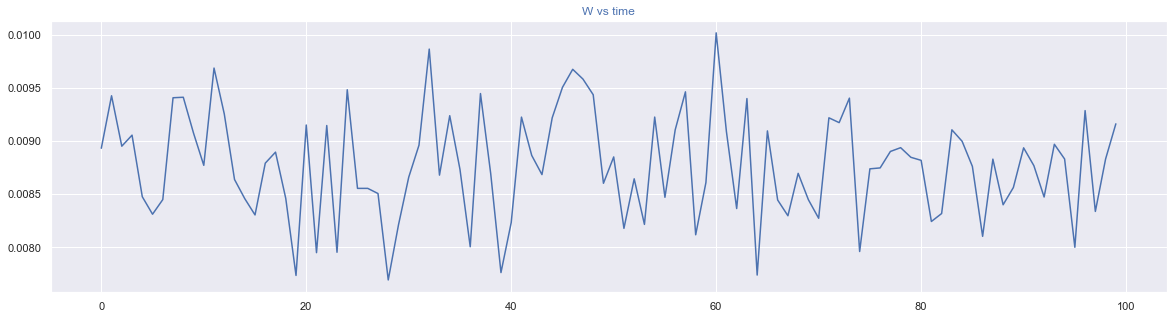

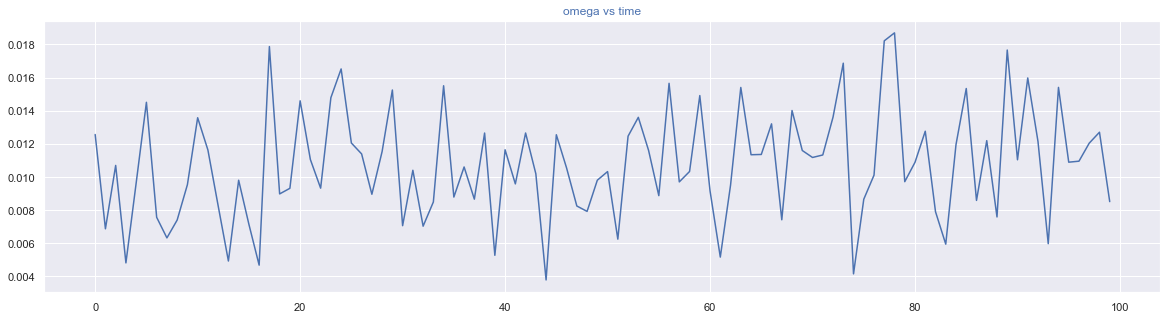

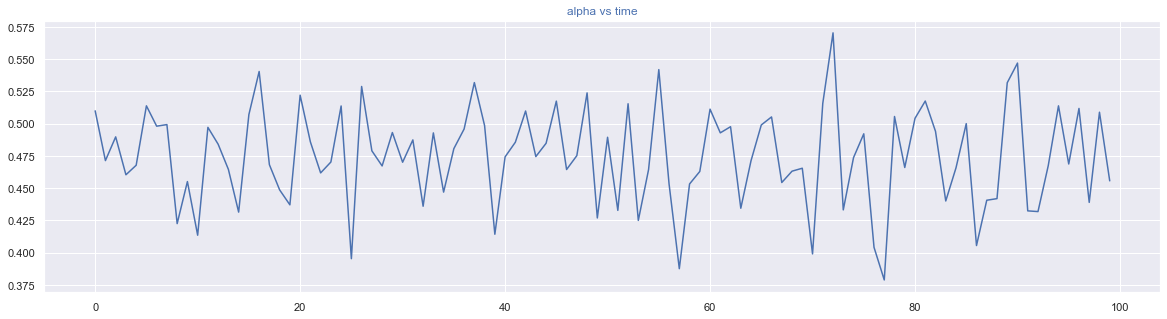

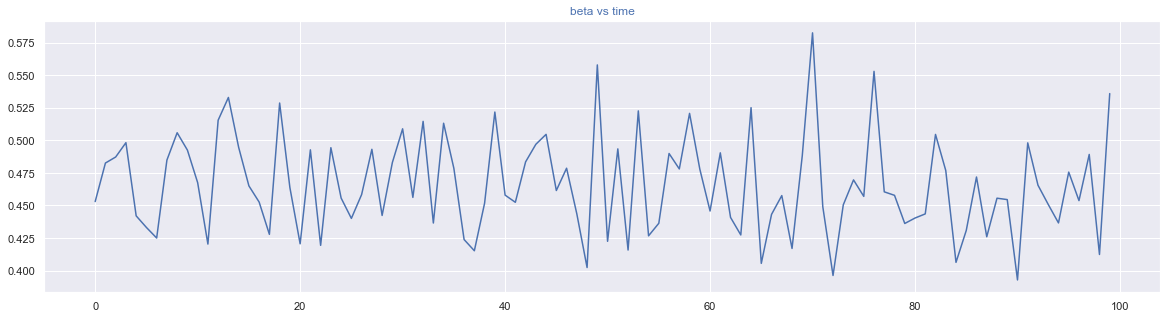

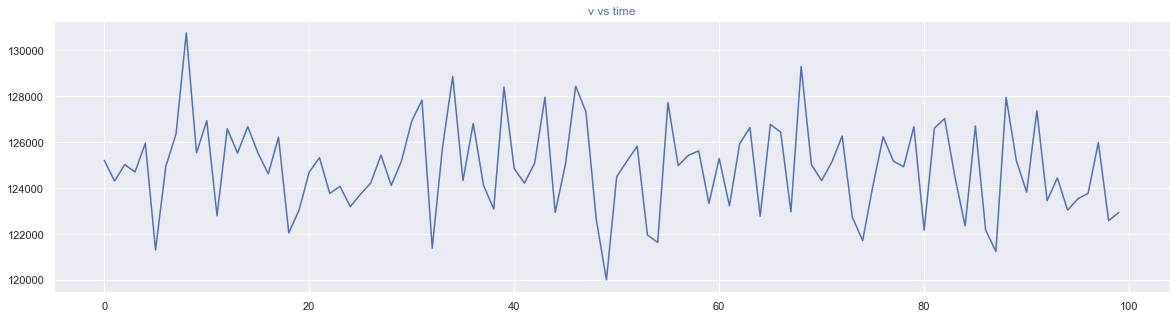

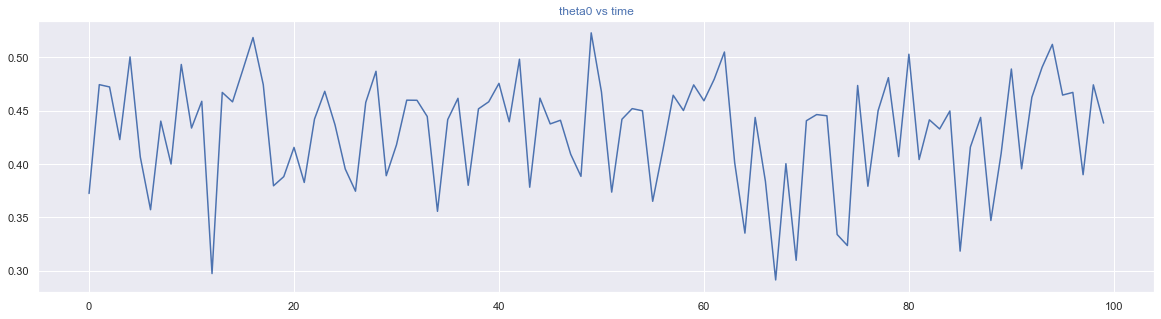

In [44]:
sns.set()
fig, ax = plt.subplots(figsize=(20, 5))
ax.set_title('W vs time'.format("seaborn"), color='C0')   
ax.plot([j for j in range(len(traj_W))], [float(j) for j in traj_W])
plt.show()

fig, ax = plt.subplots(figsize=(20, 5))
ax.set_title('omega vs time'.format("seaborn"), color='C0')   
ax.plot([j for j in range(len(traj_omega))], [float(j) for j in traj_omega])
plt.show()

fig, ax = plt.subplots(figsize=(20, 5))
ax.set_title('alpha vs time'.format("seaborn"), color='C0')   
ax.plot([j for j in range(len(traj_alpha))], [float(j) for j in traj_alpha])
plt.show()

fig, ax = plt.subplots(figsize=(20, 5))
ax.set_title('beta vs time'.format("seaborn"), color='C0')   
ax.plot([j for j in range(len(traj_beta))], [float(j) for j in traj_beta])
plt.show()

fig, ax = plt.subplots(figsize=(20, 5))
ax.set_title('v vs time'.format("seaborn"), color='C0')   
ax.plot([j for j in range(len(traj_v))], [float(j) for j in traj_v])
plt.show()

fig, ax = plt.subplots(figsize=(20, 5))
ax.set_title('theta0 vs time'.format("seaborn"), color='C0')   
ax.plot([j for j in range(len(traj_theta_0))], [float(j) for j in traj_theta_0])
plt.show()

[array([[0.00892886]]),
 array([[0.00942331]]),
 array([[0.00894839]]),
 array([[0.00905239]]),
 array([[0.00847238]]),
 array([[0.0083076]]),
 array([[0.00844556]]),
 array([[0.00940465]]),
 array([[0.00940928]]),
 array([[0.00907119]]),
 array([[0.00876807]]),
 array([[0.00968418]]),
 array([[0.00925218]]),
 array([[0.0086347]]),
 array([[0.00845412]]),
 array([[0.00830092]]),
 array([[0.00878842]]),
 array([[0.00889224]]),
 array([[0.00845614]]),
 array([[0.00773099]]),
 array([[0.00914778]]),
 array([[0.0079456]]),
 array([[0.00914304]]),
 array([[0.00794924]]),
 array([[0.00947998]]),
 array([[0.00855096]]),
 array([[0.00855108]]),
 array([[0.00850247]]),
 array([[0.00768857]]),
 array([[0.00820759]]),
 array([[0.00865669]]),
 array([[0.00895786]]),
 array([[0.0098629]]),
 array([[0.00867573]]),
 array([[0.00923556]]),
 array([[0.00872941]]),
 array([[0.0080012]]),
 array([[0.00944419]]),
 array([[0.00868841]]),
 array([[0.00775798]]),
 array([[0.00822939]]),
 array([[0.00922228]]